<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Explain what the non-linearity correction of a spectrometer is
- Define calibration function that includes the spectral non-lineary effect
- Propagate random and systematic uncertainty with the `punpy` Monte Carlo framework

# Prerequisites

- Understanding of Piccolo spectrometer data processing explained in [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)
- Understanding of random and systematic uncertainty propagation during the radiometric correction process [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)
- Understanding of random and systematic uncertainty propagation during the reflectance computation [case_1-Ex1.2_UPropagation_Noise_Cal.ipynb](case_1-Ex1.2_UPropagation_Noise_Cal.ipynb)

*code from those notebooks is provided below without any explanation, pease refer to the respective notebook if something is unclear*

# TOC

1. [Piccolo data reading](#1)
2. [Non-linearity correction](#2)
    1. [2-1](#2-1) Polynomial set
    2. [2-2](#2-2) New calibration coefficients set
4. [Propagation of uncertainty in radiance (L) and irradiance (E)](#3)
5. [Propagation of uncertainty in reflectance (R)](#4)
6. [Export](#5)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 1
## Piccolo data reading

For details on data reading, please, refer to the notebook [case_1-Ex0-Piccolo.ipynb](case_1-Ex0-Piccolo.ipynb)

Reflectance measurements using a spectrometer system (Piccolo doppio)

[back to TOC](#TOC)

In [2]:
data_dir = Path(r'../data/case1-set1')

data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

In [3]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [4]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### Irradiance (E)

In [5]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


#### Integration time correction

In [6]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [7]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

# 2

## non-lineary correction

[back to TOC](#TOC)

## 2-1
### Polynomial set

Piccolo spectrometer system provides coefficients of an 7-degree polynomial to correct for non-linear detector response throught the wavelength range.

The polynomial returns coefficients based on the raw DN readings (without integration time normalization) but with the dark current subtraction.

The coefficients are computed with the `np.polyval()` https://numpy.org/doc/stable/reference/generated/numpy.polyval.html

### radiance (L)

In [8]:
C_nonlin_L0 = data['NonLinCoeffsS2_man_L']
C_nonlin_L0_transp = C_nonlin_L0.transpose()
C_nonlin_L0_transp

array([-2.9567900e-37,  1.8114699e-31, -4.4188601e-26,  5.4452601e-21,
       -3.5208600e-16,  9.8737199e-12,  4.6739501e-08,  9.9326301e-01])

In [9]:
DN_DC_Rad = (DataL0_Rad - Datadark_Rad).mean(axis=1)

CorNonlin_L0 = 1 / np.polyval(C_nonlin_L0_transp, DN_DC_Rad) # correction factor for nonlin
CorNonlin_L0

array([1.00659679, 1.0065862 , 1.00657745, ..., 1.00676311, 1.00676318,
       1.00676307])

### irradiance (E)

In [10]:
C_nonlin_E0 = data['NonLinCoeffsS2_man_E']
C_nonlin_E0_transp = C_nonlin_E0.transpose()
C_nonlin_E0_transp

array([-2.9567900e-37,  1.8114699e-31, -4.4188601e-26,  5.4452601e-21,
       -3.5208600e-16,  9.8737199e-12,  4.6739501e-08,  9.9326301e-01])

In [11]:
DN_DC_Irrad = (DataE0_Irrad - Datadark_Irrad).mean(axis=1)

CorNonlin_E0 = 1 / np.polyval(C_nonlin_E0_transp, DN_DC_Irrad) # correction factor for nonlin
CorNonlin_E0

array([1.00159779, 1.0014813 , 1.0014134 , ..., 1.00675779, 1.00675783,
       1.00675782])

### plotting

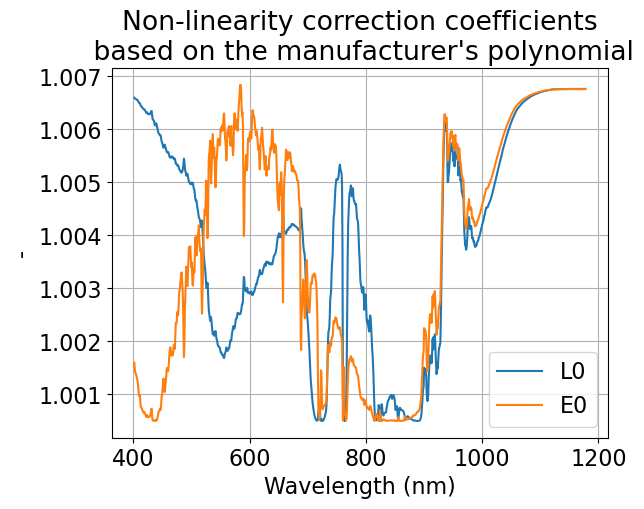

In [12]:
plt.plot(Wvl, CorNonlin_L0, label='L0')
plt.plot(Wvl, CorNonlin_E0, label='E0')
plt.legend()
plt.title("Non-linearity correction coefficients\n based on the manufacturer's polynomial")

plt.xlabel("Wavelength (nm)")
plt.ylabel("-")
plt.grid()

## 2-2
### New calibration coefficients set

For this polynomial another set of callibration coefficients was measured in the laboratory that is read from ``data['CcalS2_L_nonlin']``

In [13]:
cal_coef_L0_nonlin = data['CcalS2_L_nonlin'] # calibration coeffs from lab cal corrected for nonlin 
cal_coef_E0_nonlin = data ['CcalS2_E_nonlin'] # calibration coeffs from lab cal corrected for nonlin 

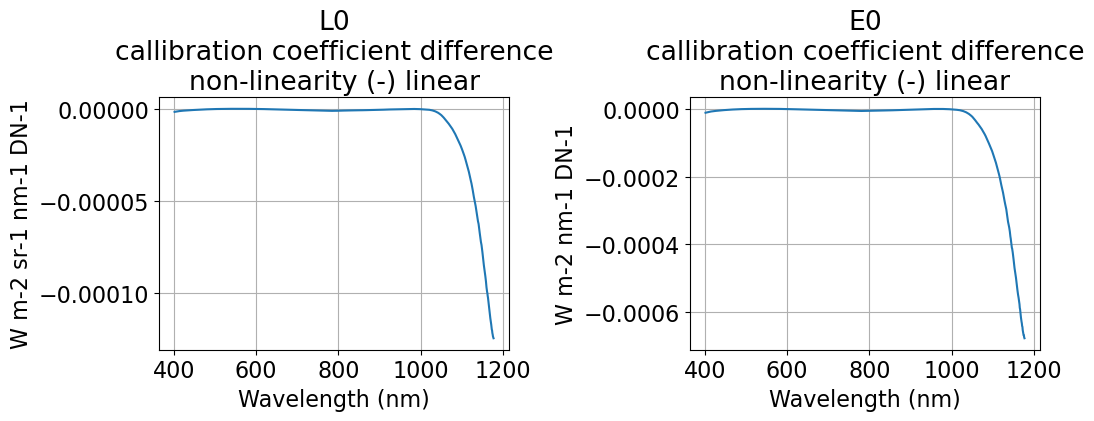

In [14]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

ax = axs[0]
ax.plot(Wvl, cal_coef_L0_nonlin - cal_coef_L0)
ax.set_title('L0\ncallibration coefficient difference\nnon-linearity (-) linear')
ax.set_ylabel("W m-2 sr-1 nm-1 DN-1")

ax = axs[1]
ax.plot(Wvl, cal_coef_E0_nonlin - cal_coef_E0)
ax.set_title('E0\ncallibration coefficient difference\nnon-linearity (-) linear')
ax.set_ylabel("W m-2 nm-1 DN-1")

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()

# 3

## Propagation of uncertainty in radiance (L) and irradiance (E)

[back to TOC](#TOC)

For details on data reading, please, refer to the notebook [case_1-Ex1.1_UPropagation_Noise_Cal.ipynb](case_1-Ex1.1_UPropagation_Noise_Cal.ipynb)

What has changed now is the introduction non-linearity correction coefficients to the propagation function

in the former notebooks (without non-linearity correction)

```python
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef
```
now (with non-linearity correction)

```python
def calibrate_nonlin(light_meas, dark_meas, cal_coef, nonlin_coef):
    return (light_meas - dark_meas) * cal_coef * nonlin_coef
```

Currently, there are **four** inputs to the function through which we want to propagate uncertainty.

Therefore, we have to estimate $U_R$ and $U_S$ of the fourth input `nonlin_coef` as well.

This will be done as for the `cal_coef`:
- $U_R$ = 0 for all wavelength
- $U_S$ = difference between uncorrected and non-linearity corrected values, divided by the non-linearity corrected values 

In [15]:
prop = punpy.MCPropagation(10000)

In [16]:
## propagation function
def calibrate_nonlin(light_meas, dark_meas, cal_coef_nonlin, nonlin_coef):
    return (light_meas - dark_meas) * cal_coef_nonlin * nonlin_coef

In [17]:
## helper function to derive nonlinearity uncertainty
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

### radiance (L)

In [18]:
## mean value
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

L1 = calibrate_nonlin(L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0)

## random uncertainty
L0_ur = np.std(L0, axis=1) / (N_L**0.5) 
dark_L0_ur = np.std(dark_L0, axis=1) / (M_L**0.5)

## propagtaion of U_R
L1_ur = prop.propagate_random(calibrate_nonlin,
                              [L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0],
                              [L0_ur, dark_L0_ur, np.zeros(len(Wvl)), np.zeros(len(Wvl))])  

## systematic uncertainty
L0_assumed_us_perc = 3 # in percents
L0_cert_us_rel = np.ones(len(Wvl)) * L0_assumed_us_perc / 100
cCalL_us_abs = L0_cert_us_rel * cal_coef_L0_nonlin  # is the absolute uncertainty of the standard instrument used for calibration

#################################################################
## non-linearity
L1_uncorrected = calibrate(L0_m, dark_L0_m, cal_coef_L0)
L1_nonlin_dev = abs((L1_uncorrected - L1) / L1)
#################################################################

## propagtaion of U_S
L1_us = prop.propagate_systematic(calibrate_nonlin, 
                                  [L0_m, dark_L0_m, cal_coef_L0_nonlin, CorNonlin_L0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalL_us_abs, L1_nonlin_dev])

L1_ut = (L1_ur ** 2 + L1_us ** 2) ** 0.5 # total uncertainty

### irradiance (E)

In [19]:
## mean value
E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)

E1 = calibrate_nonlin(E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0)

## random uncertainty
E0_ur = np.std(E0, axis=1) / (N_E ** 0.5) 
dark_E0_ur = np.std(dark_E0, axis=1) / (M_E ** 0.5)

## propagtaion of U_R
E1_ur = prop.propagate_random(calibrate_nonlin,
                              [E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0],
                              [E0_ur, dark_E0_ur, np.zeros(len(Wvl)), np.zeros(len(Wvl))])  


## systematic uncertainty
E0_assumed_us_perc = 3 # in percents
E0_cert_us_rel = np.ones(len(Wvl)) * E0_assumed_us_perc / 100
cCalE_us_abs = E0_cert_us_rel * cal_coef_E0_nonlin  # is the absolute uncertainty of the standard instrument used for calibration


#################################################################
## non-linearity
E1_uncorrected = calibrate(E0_m, dark_E0_m, cal_coef_E0)
E1_nonlin_dev = abs((E1_uncorrected - E1) / E1)
##################################################################

## propagtaion of U_S
E1_us = prop.propagate_systematic(calibrate_nonlin, 
                                  [E0_m, dark_E0_m, cal_coef_E0_nonlin, CorNonlin_E0], 
                                  [np.zeros(len(Wvl)), np.zeros(len(Wvl)), cCalE_us_abs, E1_nonlin_dev])

E1_ut = (E1_ur ** 2 + E1_us ** 2) ** 0.5 # total uncertainty

## plotting

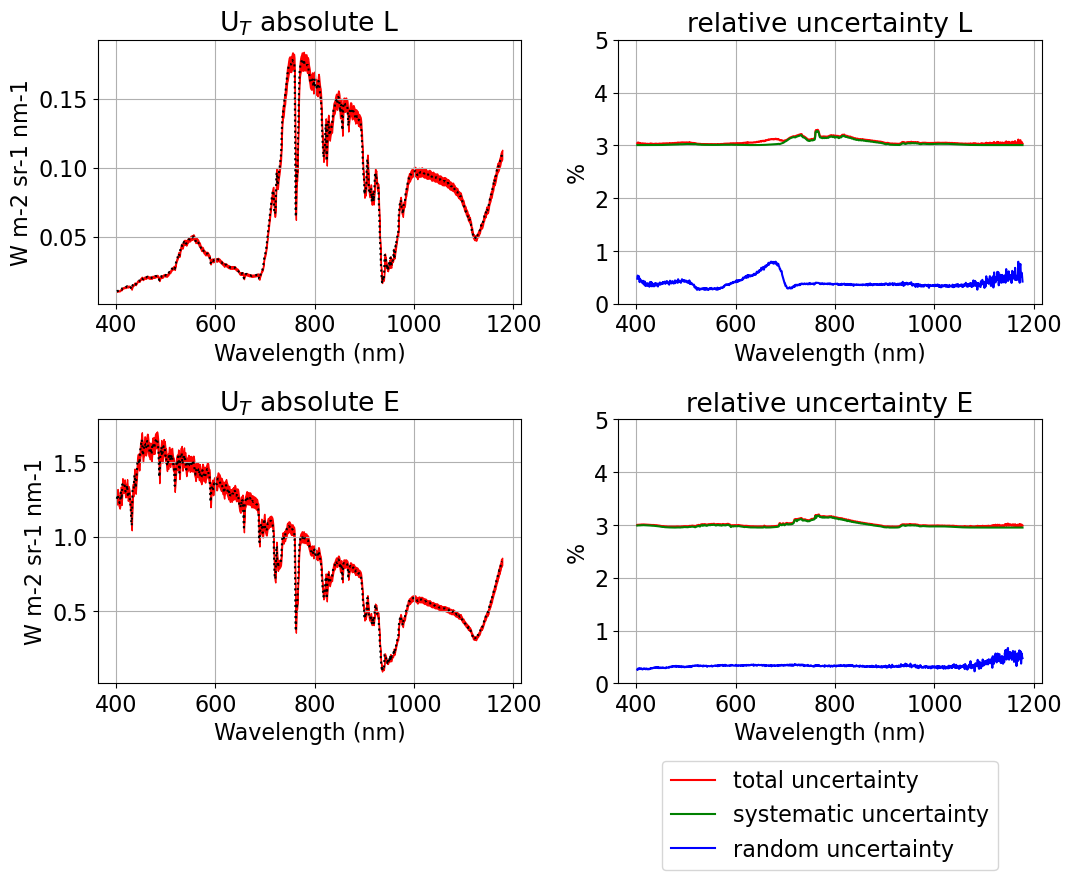

In [20]:
_, axs = plt.subplots(2, 2, figsize=(11, 9), tight_layout=True)

x = L1
ur = L1_ut
c = 'red'
utype = 'total'

ax = axs[0, 0]
ax.plot(Wvl, x, color="black", linestyle=':', label='radiance, L1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute L")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[0, 1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, L1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, L1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty L")
ax.set_ylabel('%')
ax.set_ylim([0, 5])


x = E1
ur = E1_ut
c = 'red'
utype = 'total'

ax = axs[1, 0]
ax.plot(Wvl, x, color="black", linestyle=':', label='irradiance, E1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute E")
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1, 1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, E1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, E1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty E")
ax.set_ylabel('%')
ax.set_ylim([0, 5])
ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')


for ax in axs.flatten():
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    # ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 4
## Propagation of uncertainty in reflectance (R)

[back to TOC](#TOC)

Nothing new here

In [21]:
def deriveR(L, E):
    return  (np.pi * L) / E

In [22]:
R1 = deriveR(L1, E1)

R1_ur = prop.propagate_random(deriveR, 
                              [L1, E1],
                              [L1_ur,E1_ur])

R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) 

R1_ut = (R1_ur ** 2 + R1_us ** 2) ** 0.5 # total uncertainty

In [23]:
R1_us = prop.propagate_systematic(deriveR, 
                                  [L1, E1],
                                  [L1_us, E1_us]) 

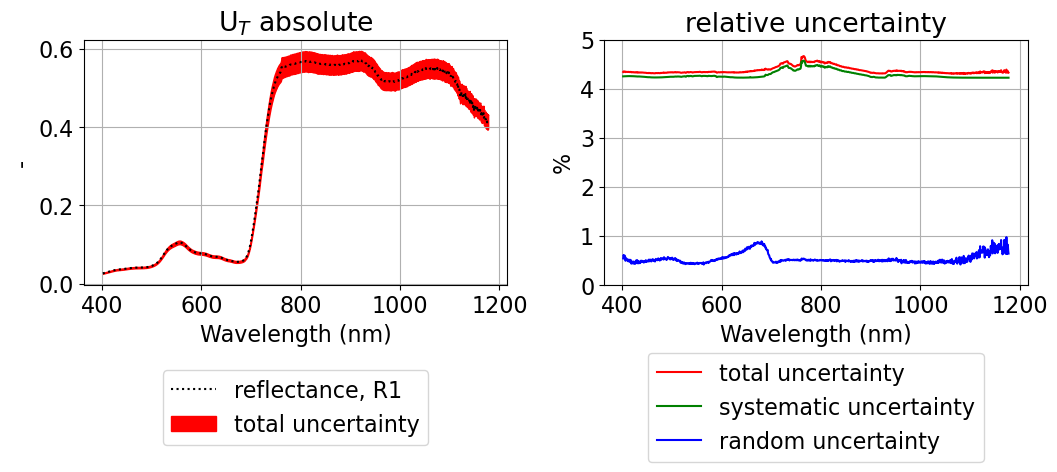

In [24]:
_, axs = plt.subplots(1, 2, figsize=(11, 4.5), tight_layout=True)

x = R1
ur = R1_ut
c = 'red'
utype = 'total'

ax = axs[0]
ax.plot(Wvl, x, color="black", linestyle=':', label='reflectance, R1')
ax.fill_between(Wvl, x - ur, x + ur, color=c, alpha=1, label=f"{utype} uncertainty")
ax.set_title("U$_T$ absolute")
ax.set_ylabel('-')

ax = axs[1]
ax.plot(Wvl, ur / x * 100, color=c, label=f"{utype} uncertainty")
ax.plot(Wvl, R1_us / x * 100, color='green', label="systematic uncertainty")
ax.plot(Wvl, R1_ur / x * 100, color='blue', label="random uncertainty")
ax.set_title(f"relative uncertainty")
ax.set_ylabel('%')
ax.set_ylim([0, 5])

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

# 5
## Export

Reflectance with its uncertainty are the inputs to the next steps retrieval and biochemical model runs.

Let's save it as a table .csv (dataframe)

[back to TOC](#TOC)

In [25]:
df = pd.DataFrame(
    {'wl': Wvl,
     'refl': R1,
     'refl_u': R1_ut
    }).set_index('wl')

df.head()

,refl,refl_u
wl,,
401.82374,0.026384,0.001146
402.61047,0.026515,0.001154
403.39714,0.026846,0.001168
404.18373,0.027021,0.001175
404.97025,0.027365,0.001191


In [26]:
# df.to_csv('R1_ut_nonlinearity.csv')